# Определение возраста покупателей

__Описание проекта__

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
 - Контролировать добросовестность кассиров при продаже алкоголя.  
 
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

__Описание данных__

Данные взяты с сайта ChaLearn Looking at People.

## Исследовательский анализ данных

Проведите исследовательский анализ данных:  
Посмотрите на размер выборки.  
Постройте график распределения возраста в выборке.  
Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.  
Сделайте выводы о том, как результаты исследования повлияют на обучение модели.  

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
features, target = next(datagen_flow)

In [5]:
print('Размер выборки:', labels.shape)

Размер выборки: (7591, 2)


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


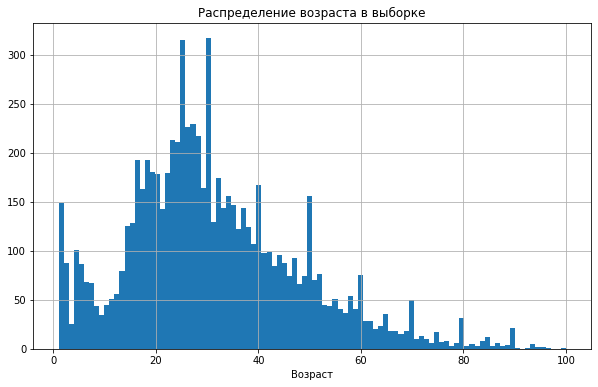

In [8]:
labels['real_age'].hist(bins=100, figsize=(10,6));
plt.title('Распределение возраста в выборке');
plt.xlabel('Возраст');

Смещение в сторону молодого возраста может привести к смещению модели в сторону более представительных категорий. Кроме того, модель может обучиться на основе характеристик данных категорий, которые не будут работать для других возрастов, что также может привести к низкому качеству предсказаний.

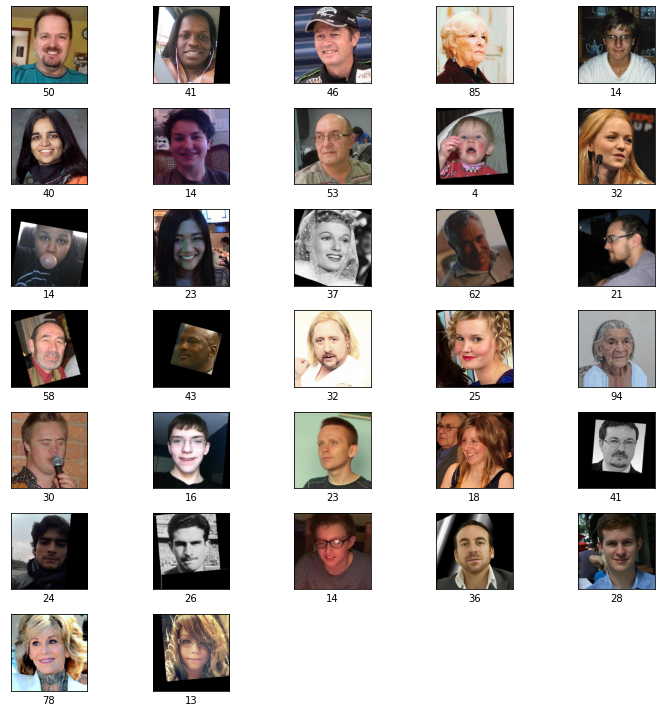

In [9]:
fig = plt.figure(figsize=(10,10))
for i in range(32):
    fig.add_subplot(7, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(target[i])
    plt.tight_layout()

### Выводы.

1. В датасете есть выбросы по возрасту в 25, 30, 40, 50, 60, 65, 70, 75, 80, 90 и 1-2, 4-7 лет - таких фото больше, чем с соседним возрастом. Пики на "юбилейных" годах получились, возможно, из-за особенностей сбора данных. Возможно, пользователями более активно загружались фото с дней рождений или люди сами меняли свой возраст в удобную им сторону. Или разметку делали другие люди, не знающие возраст точно.
2. Детские фото до 5 лет (в таком возрасте не ходят за покупками) в выборке имеют смысл для обучения, если дети покупателей тоже будут попадать в фотофиксацию в прикассовой зоне. 

## Обучение модели

Перенесем сюда код обучения модели и её результат вывода на экран.

Построим и обучим свёрточную нейронную сеть на датасете с фотографиями людей. Постараемся получить значение MAE на тестовой выборке не больше 8.

```python

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense  
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

    
def load_train(path):
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42)
    
    return train_gen_flow

def load_test(path):
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    val_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=42)
    
    return val_gen_flow    
    

def create_model(input_shape):    

    backbone = ResNet50(input_shape=input_shape,
                        #weights='imagenet',
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=0.0001)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model

 
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

```

```
2023-07-07 15:50:57.484286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-07-07 15:50:57.494557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-07-07 15:50:57.668394: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-07-07 15:50:57.675491: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2023-07-07 15:50:57.675885: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x576acb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-07-07 15:50:57.675910: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-07-07 15:50:57.823324: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4dcafd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-07 15:50:57.823363: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-07-07 15:50:57.825754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-07-07 15:50:57.830297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-07-07 15:50:57.830358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-07 15:50:58.153325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-07-07 15:50:58.153380: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-07-07 15:50:58.153388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-07-07 15:50:58.157896: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-07 15:50:58.157945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/5
2023-07-07 15:51:08.305440: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-07 15:51:08.610477: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 47s - loss: 214.6004 - mae: 10.5048 - val_loss: 838.0453 - val_mae: 24.0140
Epoch 2/5
356/356 - 38s - loss: 67.9699 - mae: 6.2411 - val_loss: 184.1963 - val_mae: 10.8569
Epoch 3/5
356/356 - 38s - loss: 36.3879 - mae: 4.6458 - val_loss: 90.8766 - val_mae: 7.1659
Epoch 4/5
356/356 - 39s - loss: 24.5366 - mae: 3.8347 - val_loss: 71.2396 - val_mae: 6.3697
Epoch 5/5
356/356 - 41s - loss: 16.7142 - mae: 3.1164 - val_loss: 84.4637 - val_mae: 7.1133
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 84.4637 - mae: 7.1133
Test MAE: 7.1133

```

## Анализ обученной модели

1. В датасете есть выбросы по возрасту в 25, 30, 40, 50, 60, 65, 70, 75, 80, 90 и 1-2, 4-7 лет - таких фото больше, чем с соседним возрастом. Пики на "юбилейных" годах получились, возможно, из-за особенностей сбора данных. Возможно, пользователями более активно загружались фото с дней рождений или люди сами меняли свой возраст в удобную им сторону. Явных несоответствий указанного возраста и лица на изображениях я не обнаружила (изучала все фото с real_age = 1 год и 30 лет). 
2. Детские фото до 5 лет (в таком возрасте не ходят за покупками) в выборке имеют смысл для обучения, если дети покупателей тоже будут попадать в фотофиксацию в прикассовой зоне.
3. У обученной модели MAE = 7.11, что недостаточно точно для продажи алкоголя, но вполне достаточно для предложения товаров по возрастным группам.